In [1]:
import os
import re
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(50)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()
farthest_point = manager.dict()

# Non shared resources
epochs = 10
batch_size = 64
sequence_length = 80

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/multi-label-hate-speech/re_dataset.csv', encoding='latin-1')

alay_dict = pd.read_csv('/kaggle/input/multi-label-hate-speech/new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original', 
                                      1: 'replacement'})

print("Shape: ", data.shape)
data.head()

Shape:  (13169, 13)


,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [7]:
def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('url', ' ', text) # Remove every URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub(r'\b(?:x[a-fA-F0-9]{2}\s*)+\b', '', text) # Remove emoji bytecode
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

print("remove_nonaplhanumeric: ", remove_nonaplhanumeric("Halooo,,,,, duniaa \x8f \xd2\1 !!"))
print("lowercase: ", lowercase("Halooo, duniaa!"))
print("remove_unnecessary_char: ", remove_unnecessary_char("Hehe\n\n RT USER USER apa kabs www.google.com\n  hehe URL xf8 x2a x89"))
print("normalize_alay: ", normalize_alay("aamiin adek abis"))

remove_nonaplhanumeric:  Halooo duniaa 
lowercase:  halooo, duniaa!
remove_unnecessary_char:  Hehe RT USER USER apa kabs hehe URL 
normalize_alay:  amin adik habis


In [8]:
def preprocess(text):
    text = lowercase(text)
    text = remove_nonaplhanumeric(text)
    text = remove_unnecessary_char(text)
    text = normalize_alay(text) 

    return text

In [9]:
data['Tweet'] = data['Tweet'].apply(preprocess)

# Define the labels columns for multi-label classification
label_columns = data.columns[1:]  # Assuming label columns start from the third column

train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

# Extract features and labels for training and validation
X_train = train_data['Tweet'].values
y_train = train_data[label_columns].values
X_val = val_data['Tweet'].values
y_val = val_data[label_columns].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(10535,) (10535, 12)
(2634,) (2634, 12)


# BULDING DATASET

In [10]:
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float if self.use_float else torch.long)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [11]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=sequence_length, num_workers=4):
    train_dataset = HateSpeechDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = HateSpeechDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

In [12]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 200

In [13]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate', 'HS_Strong'],
        zero_division=0
    )   
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [14]:
def train_model(current_train_size, train_indices, metrics, trials, seed, filename):
    accelerator = Accelerator(mixed_precision='fp16')
    device = accelerator.device
    accelerator.print(accelerator.distributed_type)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(label_columns),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")

            nearest_cp = current_train_size
            if nearest_cp not in checkpoints:
                for cp in checkpoints:
                    if cp > current_train_size:
                        nearest_cp = cp
                        break
            percentage = math.ceil(nearest_cp / total_data * 100)
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-model-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"\n Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Training completed in {duration} s")

    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

In [15]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

In [ ]:
def combined_sampling(model, farthest_point, X_pool, train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, trials, filename):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device
    model.to(device)
    
    current_train_size = len(train_indices)
    
    # Check nearest checkpoint
    nearest_cp = 0
    for cp in checkpoints:
        if cp > current_train_size:
            nearest_cp = cp
            break

    target_samples = math.ceil(0.1*len(remaining_indices))
    if target_samples <= min_increment and min_increment < nearest_cp - current_train_size:
        target_samples = min_increment
    elif target_samples > min_increment and target_samples < nearest_cp - current_train_size:
        target_samples = target_samples
    else:
        target_samples = nearest_cp - current_train_size

    final_cp = False
    # No sampling needed when there's little data left or we've reached the last checkpoint
    if current_train_size >= checkpoints[-1] - target_samples:
        final_cp = True

        if accelerator.is_main_process:
            temp = train_indices.copy()
            temp.extend(remaining_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'HS': [y_train[i][0] for i in temp],
                'Abusive': [y_train[i][1] for i in temp],
                'HS_Individual': [y_train[i][2] for i in temp],
                'HS_Group': [y_train[i][3] for i in temp],
                'HS_Religion': [y_train[i][4] for i in temp],
                'HS_Race': [y_train[i][5] for i in temp],
                'HS_Physical': [y_train[i][6] for i in temp],
                'HS_Gender': [y_train[i][7] for i in temp],
                'HS_Other': [y_train[i][8] for i in temp],
                'HS_Weak': [y_train[i][9] for i in temp],
                'HS_Moderate': [y_train[i][10] for i in temp],
                'HS_Strong': [y_train[i][11] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-data-{nearest_cp}.csv', index=False)
            
            print("Nearest checkpoint:", nearest_cp)
            print("Acquired samples:", len(remaining_indices))
            
            sampling_dur.append(0)
            for i in remaining_indices:
                new_samples.append(i)

    accelerator.wait_for_everyone()
    if not final_cp:
        # Create dataset and dataloader for both methods
        dataset = HateSpeechDataset(X_pool, np.zeros((len(X_pool), 4)), tokenizer, max_length=sequence_length)
        dataloader = DataLoader(
            dataset,
            batch_size=batch_size,
            num_workers=4,
            pin_memory=True,
        )
        
        # Start timing
        start_time = time.time()
        
        # Get Coreset samples
        coreset_samples = get_coreset_samples(model, farthest_point, dataloader, dataset, device, target_samples)
        coreset_samples = [remaining_indices[i] for i in coreset_samples]
        accelerator.print(f"Got {len(coreset_samples)} samples from coreset")
        
        # Get Least Confidence samples
        lc_indices = get_least_confidence_samples(model, dataloader, device, target_samples)
        lc_indices = [remaining_indices[i] for i in lc_indices]
        accelerator.print(f"Got {len(lc_indices)} samples from lc")
    
        if accelerator.is_main_process:
            # Combine both methods' results
            combined_indices = list(set(coreset_samples).union(set(lc_indices)))
            
            # If we got more than we need, take only what we need
            if len(combined_indices) > target_samples:
                np.random.shuffle(combined_indices)
                combined_indices = combined_indices[:target_samples]
            
            # Calculate duration
            end_time = time.time()
            duration = end_time - start_time
            
            # Check if we've reached a checkpoint
            if current_train_size + len(combined_indices) >= nearest_cp:
                temp = train_indices.copy()
                temp.extend(combined_indices)
                
                # Save acquired data up to checkpoint
                acquired_data = pd.DataFrame({
                    'processed_text': [X_train[i] for i in temp],
                    'HS': [y_train[i][0] for i in temp],
                    'Abusive': [y_train[i][1] for i in temp],
                    'HS_Individual': [y_train[i][2] for i in temp],
                    'HS_Group': [y_train[i][3] for i in temp],
                    'HS_Religion': [y_train[i][4] for i in temp],
                    'HS_Race': [y_train[i][5] for i in temp],
                    'HS_Physical': [y_train[i][6] for i in temp],
                    'HS_Gender': [y_train[i][7] for i in temp],
                    'HS_Other': [y_train[i][8] for i in temp],
                    'HS_Weak': [y_train[i][9] for i in temp],
                    'HS_Moderate': [y_train[i][10] for i in temp],
                    'HS_Strong': [y_train[i][11] for i in temp],
                })
                acquired_data.to_csv(f'acquired_data/{filename}-data-{nearest_cp}.csv', index=False)
            
            # Log results
            print("Nearest checkpoint:", nearest_cp)
            print(f"Acquired samples: {len(combined_indices)}")
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in combined_indices:
                new_samples.append(i)

def get_coreset_samples(model, farthest_point, dataloader, dataset, device, n_samples, n_clusters=min_increment):
    model.eval()
    embeddings = []
    farthest_data = dict(farthest_point)
    
    # Get embeddings
    with torch.no_grad():
        for data in dataloader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            outputs = model.base_model(input_ids=input_ids, attention_mask=attention_mask)
            hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
            embeddings.append(hidden_states.cpu().numpy())

    if 'input_ids' in farthest_data:
        with torch.no_grad():
            outputs = model.base_model(
                input_ids=farthest_data['input_ids'].unsqueeze(0).to(device, non_blocking=True), 
                attention_mask=farthest_data['attention_mask'].unsqueeze(0).to(device, non_blocking=True)
            )
            hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
            embeddings.append(hidden_states.cpu().numpy())
    
    # Convert embeddings list to numpy array
    embeddings = np.vstack(embeddings)
    embeddings = np.array(embeddings)

    distance_matrix = pairwise_distances(embeddings)    
    selected_indices = distance_matrix.shape[0] - 1 if 'input_ids' in farthest_data else 0
    
    min_distances = distance_matrix[selected_indices]
    sorted_dist = np.argsort(min_distances)
    sorted_dist = sorted_dist[::-1]
    farthest_point['input_ids'] = dataset[sorted_dist[0]]['input_ids']
    farthest_point['attention_mask'] = dataset[sorted_dist[0]]['attention_mask']

    threshold = np.percentile(min_distances, 90)
    candidates = np.where(min_distances >= threshold)[0]  # Select the point farthest from the current set
    num_of_candidates = len(candidates)

    return sorted_dist[:n_samples]

def get_least_confidence_samples(model, dataloader, device, n_samples):
    model.eval()
    uncertainties = []
    
    # Calculate uncertainties
    for data in dataloader:
        input_ids = data['input_ids'].to(device, non_blocking=True)
        attention_mask = data['attention_mask'].to(device, non_blocking=True)
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits
        
        for output in outputs:
            probs = torch.sigmoid(output).cpu().numpy()
            uncertainty = np.absolute(1 - np.max(probs))
            uncertainties.append(uncertainty)
    
    uncertainties = np.array(uncertainties)
    sorted_unc = np.argsort(uncertainties)
    sorted_unc = sorted_unc[::-1]  # Reverse to get highest uncertainty first

    threshold = np.percentile(uncertainties, 90)
    items_greater_than_average = uncertainties[uncertainties >= threshold]
    least_confident_indices = sorted_unc[:n_samples]

    return least_confident_indices

In [17]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()
    farthest_point = manager.dict()
    filename = 'hsd-lc-coreset'

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed, filename)
        notebook_launcher(train_model, args, num_processes=2)

        nearest_cp = current_train_size
        if nearest_cp not in checkpoints:
            for cp in checkpoints:
                if cp > current_train_size:
                    nearest_cp = cp
                    break
        percentage = math.ceil(nearest_cp / total_data * 100)
        
        model = BertForSequenceClassification.from_pretrained(f'{filename}-model-{percentage}')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (model, farthest_point, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, i, filename)
        notebook_launcher(combined_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed, filename)
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-results.csv', index=False)

In [18]:
seeds = [50, 81, 14, 3, 94]

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6065, Accuracy: 0.8198, F1 Micro: 0.122, F1 Macro: 0.0444
Epoch 2/10, Train Loss: 0.4617, Accuracy: 0.8278, F1 Micro: 0.0007, F1 Macro: 0.0003
Epoch 3/10, Train Loss: 0.3954, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 4/10, Train Loss: 0.3949, Accuracy: 0.8281, F1 Micro: 0.0036, F1 Macro: 0.0016
Epoch 5/10, Train Loss: 0.3769, Accuracy: 0.8324, F1 Micro: 0.0595, F1 Macro: 0.0247
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3696, Accuracy: 0.8475, F1 Micro: 0.2419, F1 Macro: 0.0856
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3475, Accuracy: 0.8544, F1 Micro: 0.3196, F1 Macro: 0.1086
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3336, Accuracy: 0.8698, F1 Micro: 0.4829, F1 Macro: 0.2106
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2992, Accuracy: 0.8751, F1 Micro: 0.5435, F1 Macro: 0.2653
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.2712, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4973, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3214, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2927, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2621, Accuracy: 0.8415, F1 Micro: 0.1839, F1 Macro: 0.0679
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2394, Accuracy: 0.8615, F1 Micro: 0.3909, F1 Macro: 0.1841
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2083, Accuracy: 0.875, F1 Micro: 0.5979, F1 Macro: 0.3687
Epoch 7/10, Train Loss: 0.1699, Accuracy: 0.8761, F1 Micro: 0.5639, F1 Macro: 0.3641
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1737, Accuracy: 0.8797, F1 Micro: 0.6023, F1 Macro: 0.3887
Epoch 9/10, Train Loss: 0.1526, Accuracy: 0.8794, F1 Micro: 0.5583, F1 Macro: 0.3578
Higher F1 achieved, sav

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4641, Accuracy: 0.8278, F1 Micro: 0.0014, F1 Macro: 0.0006
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3042, Accuracy: 0.8453, F1 Micro: 0.4675, F1 Macro: 0.2109
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2534, Accuracy: 0.8668, F1 Micro: 0.527, F1 Macro: 0.2417
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2227, Accuracy: 0.8762, F1 Micro: 0.5704, F1 Macro: 0.3005
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1894, Accuracy: 0.881, F1 Micro: 0.6083, F1 Macro: 0.3853
Epoch 6/10, Train Loss: 0.1741, Accuracy: 0.8834, F1 Micro: 0.5894, F1 Macro: 0.3825
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1587, Accuracy: 0.8877, F1 Micro: 0.6218, F1 Macro: 0.3975
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1401, Accuracy: 0.8908, F1 Micro: 0.6397, F1 Macro: 0.4497
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1265, Accuracy: 0.8938, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4217, Accuracy: 0.8297, F1 Micro: 0.0245, F1 Macro: 0.0107
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.285, Accuracy: 0.8623, F1 Micro: 0.4656, F1 Macro: 0.2133
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2301, Accuracy: 0.8761, F1 Micro: 0.5278, F1 Macro: 0.3149
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1818, Accuracy: 0.8828, F1 Micro: 0.593, F1 Macro: 0.368
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1643, Accuracy: 0.8878, F1 Micro: 0.6058, F1 Macro: 0.4203
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1418, Accuracy: 0.8913, F1 Micro: 0.6758, F1 Macro: 0.4952
Epoch 7/10, Train Loss: 0.1265, Accuracy: 0.8954, F1 Micro: 0.637, F1 Macro: 0.4873
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1117, Accuracy: 0.8921, F1 Micro: 0.6892, F1 Macro: 0.5418
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0963, Accuracy: 0.8982, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4133, Accuracy: 0.8362, F1 Micro: 0.1808, F1 Macro: 0.076
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2756, Accuracy: 0.8682, F1 Micro: 0.5519, F1 Macro: 0.2614
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2126, Accuracy: 0.8787, F1 Micro: 0.6074, F1 Macro: 0.4101
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1842, Accuracy: 0.8865, F1 Micro: 0.6452, F1 Macro: 0.4468
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.158, Accuracy: 0.8934, F1 Micro: 0.6609, F1 Macro: 0.4503
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1446, Accuracy: 0.8966, F1 Micro: 0.6779, F1 Macro: 0.4837
Epoch 7/10, Train Loss: 0.1203, Accuracy: 0.8986, F1 Micro: 0.6709, F1 Macro: 0.5128
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1037, Accuracy: 0.901, F1 Micro: 0.7022, F1 Macro: 0.5863
Epoch 9/10, Train Loss: 0.0853, Accuracy: 0.8985, F1 Micro: 0.6943, F1 Macro: 0.5836
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3999, Accuracy: 0.8402, F1 Micro: 0.2287, F1 Macro: 0.0937
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2596, Accuracy: 0.874, F1 Micro: 0.5864, F1 Macro: 0.3241
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2019, Accuracy: 0.8852, F1 Micro: 0.6195, F1 Macro: 0.3665
Epoch 4/10, Train Loss: 0.1768, Accuracy: 0.8899, F1 Micro: 0.6094, F1 Macro: 0.4137
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1455, Accuracy: 0.8987, F1 Micro: 0.6761, F1 Macro: 0.4759
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1333, Accuracy: 0.8925, F1 Micro: 0.6984, F1 Macro: 0.5236
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1068, Accuracy: 0.9033, F1 Micro: 0.706, F1 Macro: 0.5529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0998, Accuracy: 0.9, F1 Micro: 0.7084, F1 Macro: 0.5877
Epoch 9/10, Train Loss: 0.08, Accuracy: 0.902, F1 Micro: 0.6964, F1 Macro: 0.5813
Higher F1 ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3925, Accuracy: 0.8457, F1 Micro: 0.3054, F1 Macro: 0.1351
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2576, Accuracy: 0.8821, F1 Micro: 0.616, F1 Macro: 0.3756
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1996, Accuracy: 0.8959, F1 Micro: 0.6565, F1 Macro: 0.4547
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1698, Accuracy: 0.8998, F1 Micro: 0.6748, F1 Macro: 0.4861
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1406, Accuracy: 0.903, F1 Micro: 0.6921, F1 Macro: 0.5104
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1252, Accuracy: 0.9055, F1 Micro: 0.7165, F1 Macro: 0.577
Epoch 7/10, Train Loss: 0.1043, Accuracy: 0.9062, F1 Micro: 0.7129, F1 Macro: 0.5831
Epoch 8/10, Train Loss: 0.0875, Accuracy: 0.9043, F1 Micro: 0.7091, F1 Macro: 0.5907
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0752, Accuracy: 0.9074, F1 Micro: 0.7181, F1 Macro: 0.6049
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3822, Accuracy: 0.8493, F1 Micro: 0.3604, F1 Macro: 0.1596
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2443, Accuracy: 0.8833, F1 Micro: 0.586, F1 Macro: 0.3523
Epoch 3/10, Train Loss: 0.1906, Accuracy: 0.8881, F1 Micro: 0.5788, F1 Macro: 0.3529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1667, Accuracy: 0.9014, F1 Micro: 0.7036, F1 Macro: 0.4907
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1409, Accuracy: 0.9036, F1 Micro: 0.712, F1 Macro: 0.5187
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1133, Accuracy: 0.902, F1 Micro: 0.7184, F1 Macro: 0.5697
Epoch 7/10, Train Loss: 0.0953, Accuracy: 0.9074, F1 Micro: 0.7093, F1 Macro: 0.5627
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0827, Accuracy: 0.9102, F1 Micro: 0.7354, F1 Macro: 0.6096
Epoch 9/10, Train Loss: 0.0745, Accuracy: 0.9013, F1 Micro: 0.7247, F1 Macro: 0.6325
Epoch 10/10, Train Loss: 0.0669, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.377, Accuracy: 0.8579, F1 Micro: 0.4295, F1 Macro: 0.1915
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2383, Accuracy: 0.8874, F1 Micro: 0.6041, F1 Macro: 0.3697
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1851, Accuracy: 0.901, F1 Micro: 0.6872, F1 Macro: 0.4663
Epoch 4/10, Train Loss: 0.1587, Accuracy: 0.9033, F1 Micro: 0.6797, F1 Macro: 0.4837
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1338, Accuracy: 0.9059, F1 Micro: 0.6994, F1 Macro: 0.4928
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1128, Accuracy: 0.9095, F1 Micro: 0.7247, F1 Macro: 0.5859
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0958, Accuracy: 0.9075, F1 Micro: 0.7301, F1 Macro: 0.5996
Epoch 8/10, Train Loss: 0.0785, Accuracy: 0.9101, F1 Micro: 0.728, F1 Macro: 0.6086
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0688, Accuracy: 0.907, F1 Micro: 0.7315, F1 Macro: 0.6248
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3746, Accuracy: 0.8557, F1 Micro: 0.3653, F1 Macro: 0.1607
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2392, Accuracy: 0.8924, F1 Micro: 0.6276, F1 Macro: 0.4024
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1847, Accuracy: 0.9009, F1 Micro: 0.6769, F1 Macro: 0.4346
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1563, Accuracy: 0.905, F1 Micro: 0.7141, F1 Macro: 0.5332
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1381, Accuracy: 0.9049, F1 Micro: 0.7188, F1 Macro: 0.5162
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1094, Accuracy: 0.909, F1 Micro: 0.7246, F1 Macro: 0.5908
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0959, Accuracy: 0.9105, F1 Micro: 0.7295, F1 Macro: 0.5852
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0775, Accuracy: 0.9091, F1 Micro: 0.7339, F1 Macro: 0.6372
Epoch 9/10, Train Loss: 0.0686, Accuracy: 0.9138, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.375, Accuracy: 0.8692, F1 Micro: 0.5028, F1 Macro: 0.2306
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2354, Accuracy: 0.8942, F1 Micro: 0.6484, F1 Macro: 0.3878
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1819, Accuracy: 0.9014, F1 Micro: 0.7058, F1 Macro: 0.5081
Epoch 4/10, Train Loss: 0.1528, Accuracy: 0.9036, F1 Micro: 0.6814, F1 Macro: 0.525
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1282, Accuracy: 0.9075, F1 Micro: 0.7297, F1 Macro: 0.5729
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.109, Accuracy: 0.9111, F1 Micro: 0.7325, F1 Macro: 0.6044
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0898, Accuracy: 0.9137, F1 Micro: 0.7409, F1 Macro: 0.6133
Epoch 8/10, Train Loss: 0.0816, Accuracy: 0.9102, F1 Micro: 0.7366, F1 Macro: 0.6291
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0632, Accuracy: 0.912, F1 Micro: 0.7422, F1 Macro: 0.6564
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3736, Accuracy: 0.8742, F1 Micro: 0.5361, F1 Macro: 0.2456
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2315, Accuracy: 0.8966, F1 Micro: 0.6544, F1 Macro: 0.4204
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1804, Accuracy: 0.8982, F1 Micro: 0.7067, F1 Macro: 0.5243
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1524, Accuracy: 0.9082, F1 Micro: 0.719, F1 Macro: 0.5231
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1324, Accuracy: 0.9088, F1 Micro: 0.7323, F1 Macro: 0.58
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1137, Accuracy: 0.9128, F1 Micro: 0.7343, F1 Macro: 0.6159
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0885, Accuracy: 0.9143, F1 Micro: 0.7384, F1 Macro: 0.6239
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0812, Accuracy: 0.9132, F1 Micro: 0.7406, F1 Macro: 0.608
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3718, Accuracy: 0.8759, F1 Micro: 0.5458, F1 Macro: 0.2527
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2346, Accuracy: 0.8983, F1 Micro: 0.6684, F1 Macro: 0.4269
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1905, Accuracy: 0.9048, F1 Micro: 0.7004, F1 Macro: 0.4921
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1567, Accuracy: 0.9035, F1 Micro: 0.7219, F1 Macro: 0.5648
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1319, Accuracy: 0.9109, F1 Micro: 0.7225, F1 Macro: 0.5859
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1106, Accuracy: 0.9133, F1 Micro: 0.7337, F1 Macro: 0.6038
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0925, Accuracy: 0.9141, F1 Micro: 0.7447, F1 Macro: 0.6339
Epoch 8/10, Train Loss: 0.0803, Accuracy: 0.9122, F1 Micro: 0.7414, F1 Macro: 0.6438
Epoch 9/10, Train Loss: 0.0669, Accuracy: 0.9156, F1 Micro: 0.7439, F1 Macro: 0.6411
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3693, Accuracy: 0.8725, F1 Micro: 0.5145, F1 Macro: 0.2439
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2329, Accuracy: 0.8972, F1 Micro: 0.6843, F1 Macro: 0.4548
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1913, Accuracy: 0.9053, F1 Micro: 0.7134, F1 Macro: 0.5376
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1596, Accuracy: 0.9085, F1 Micro: 0.7308, F1 Macro: 0.5673
Epoch 5/10, Train Loss: 0.1273, Accuracy: 0.9108, F1 Micro: 0.7303, F1 Macro: 0.5659
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1078, Accuracy: 0.9152, F1 Micro: 0.7342, F1 Macro: 0.5826
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0909, Accuracy: 0.9131, F1 Micro: 0.7483, F1 Macro: 0.6424
Epoch 8/10, Train Loss: 0.0775, Accuracy: 0.9116, F1 Micro: 0.7446, F1 Macro: 0.644
Epoch 9/10, Train Loss: 0.0678, Accuracy: 0.9156, F1 Micro: 0.7464, F1 Macro: 0.6407
Higher F1 achieved, saving model
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3691, Accuracy: 0.8749, F1 Micro: 0.5085, F1 Macro: 0.2419
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2402, Accuracy: 0.8968, F1 Micro: 0.6534, F1 Macro: 0.4664
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1856, Accuracy: 0.9051, F1 Micro: 0.7133, F1 Macro: 0.5105
Epoch 4/10, Train Loss: 0.1556, Accuracy: 0.9098, F1 Micro: 0.704, F1 Macro: 0.5259
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1339, Accuracy: 0.9123, F1 Micro: 0.7434, F1 Macro: 0.5978
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1085, Accuracy: 0.9135, F1 Micro: 0.7504, F1 Macro: 0.622
Epoch 7/10, Train Loss: 0.0911, Accuracy: 0.9157, F1 Micro: 0.7487, F1 Macro: 0.6263
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0799, Accuracy: 0.9172, F1 Micro: 0.7571, F1 Macro: 0.6624
Epoch 9/10, Train Loss: 0.0675, Accuracy: 0.9142, F1 Micro: 0.7544, F1 Macro: 0.6592
Epoch 10/10, Train Loss: 0.0588, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3729, Accuracy: 0.8784, F1 Micro: 0.5548, F1 Macro: 0.264
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2398, Accuracy: 0.9002, F1 Micro: 0.6885, F1 Macro: 0.4768
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1885, Accuracy: 0.9056, F1 Micro: 0.7227, F1 Macro: 0.538
Epoch 4/10, Train Loss: 0.1534, Accuracy: 0.9107, F1 Micro: 0.7157, F1 Macro: 0.5644
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1359, Accuracy: 0.9149, F1 Micro: 0.7562, F1 Macro: 0.6192
Epoch 6/10, Train Loss: 0.1103, Accuracy: 0.9112, F1 Micro: 0.7416, F1 Macro: 0.6309
Epoch 7/10, Train Loss: 0.0947, Accuracy: 0.9136, F1 Micro: 0.754, F1 Macro: 0.645
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0758, Accuracy: 0.9167, F1 Micro: 0.7576, F1 Macro: 0.6471
Epoch 9/10, Train Loss: 0.0715, Accuracy: 0.916, F1 Micro: 0.7543, F1 Macro: 0.6533
Epoch 10/10, Train Loss: 0.0596, Accuracy: 0.9173, F1 Micro: 0.7377, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3717, Accuracy: 0.8814, F1 Micro: 0.5941, F1 Macro: 0.2891
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2403, Accuracy: 0.8971, F1 Micro: 0.6441, F1 Macro: 0.4298
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1922, Accuracy: 0.9077, F1 Micro: 0.6921, F1 Macro: 0.4987
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1568, Accuracy: 0.9131, F1 Micro: 0.7317, F1 Macro: 0.5481
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.132, Accuracy: 0.9173, F1 Micro: 0.7497, F1 Macro: 0.6073
Epoch 6/10, Train Loss: 0.1154, Accuracy: 0.9189, F1 Micro: 0.7488, F1 Macro: 0.615
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0927, Accuracy: 0.9159, F1 Micro: 0.7524, F1 Macro: 0.6495
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0804, Accuracy: 0.9186, F1 Micro: 0.7599, F1 Macro: 0.6405
Epoch 9/10, Train Loss: 0.0682, Accuracy: 0.9181, F1 Micro: 0.7527, F1 Macro: 0.6591
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3728, Accuracy: 0.8807, F1 Micro: 0.5609, F1 Macro: 0.2703
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2388, Accuracy: 0.8978, F1 Micro: 0.6417, F1 Macro: 0.4324
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1957, Accuracy: 0.9097, F1 Micro: 0.7183, F1 Macro: 0.5362
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1625, Accuracy: 0.9133, F1 Micro: 0.7452, F1 Macro: 0.5774
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1362, Accuracy: 0.918, F1 Micro: 0.7514, F1 Macro: 0.6071
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1169, Accuracy: 0.914, F1 Micro: 0.7577, F1 Macro: 0.633
Epoch 7/10, Train Loss: 0.0981, Accuracy: 0.92, F1 Micro: 0.7532, F1 Macro: 0.6519
Epoch 8/10, Train Loss: 0.0809, Accuracy: 0.918, F1 Micro: 0.7567, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0697, Accuracy: 0.9204, F1 Micro: 0.7602, F1 Macro: 0.669
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3725, Accuracy: 0.8813, F1 Micro: 0.5777, F1 Macro: 0.2826
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2419, Accuracy: 0.903, F1 Micro: 0.6803, F1 Macro: 0.442
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1929, Accuracy: 0.9111, F1 Micro: 0.7316, F1 Macro: 0.5768
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1558, Accuracy: 0.9141, F1 Micro: 0.7431, F1 Macro: 0.5989
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1326, Accuracy: 0.9173, F1 Micro: 0.7513, F1 Macro: 0.6035
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1095, Accuracy: 0.9185, F1 Micro: 0.7575, F1 Macro: 0.647
Epoch 7/10, Train Loss: 0.094, Accuracy: 0.9177, F1 Micro: 0.7468, F1 Macro: 0.6354
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0785, Accuracy: 0.9191, F1 Micro: 0.7615, F1 Macro: 0.6471
Epoch 9/10, Train Loss: 0.0652, Accuracy: 0.9208, F1 Micro: 0.7552, F1 Macro: 0.6584
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3739, Accuracy: 0.8815, F1 Micro: 0.5899, F1 Macro: 0.3
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2469, Accuracy: 0.9028, F1 Micro: 0.7002, F1 Macro: 0.4828
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1977, Accuracy: 0.9123, F1 Micro: 0.7344, F1 Macro: 0.5621
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1584, Accuracy: 0.916, F1 Micro: 0.7507, F1 Macro: 0.5866
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1362, Accuracy: 0.9194, F1 Micro: 0.7586, F1 Macro: 0.627
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1128, Accuracy: 0.9156, F1 Micro: 0.7614, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0925, Accuracy: 0.9205, F1 Micro: 0.7639, F1 Macro: 0.6553
Epoch 8/10, Train Loss: 0.082, Accuracy: 0.9166, F1 Micro: 0.7631, F1 Macro: 0.6785
Epoch 9/10, Train Loss: 0.0686, Accuracy: 0.9167, F1 Micro: 0.7538, F1 Macro: 0.6766
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.368, Accuracy: 0.8805, F1 Micro: 0.551, F1 Macro: 0.2652
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2431, Accuracy: 0.9036, F1 Micro: 0.6814, F1 Macro: 0.4831
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1943, Accuracy: 0.9126, F1 Micro: 0.7274, F1 Macro: 0.5545
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1598, Accuracy: 0.9166, F1 Micro: 0.7483, F1 Macro: 0.606
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1345, Accuracy: 0.917, F1 Micro: 0.7588, F1 Macro: 0.6149
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1116, Accuracy: 0.9206, F1 Micro: 0.7602, F1 Macro: 0.6364
Epoch 7/10, Train Loss: 0.0926, Accuracy: 0.9202, F1 Micro: 0.7496, F1 Macro: 0.659
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0796, Accuracy: 0.9209, F1 Micro: 0.7635, F1 Macro: 0.6745
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0695, Accuracy: 0.9176, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3747, Accuracy: 0.8827, F1 Micro: 0.587, F1 Macro: 0.2913
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2457, Accuracy: 0.9003, F1 Micro: 0.7146, F1 Macro: 0.5359
Epoch 3/10, Train Loss: 0.1943, Accuracy: 0.9112, F1 Micro: 0.701, F1 Macro: 0.5044
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1612, Accuracy: 0.9183, F1 Micro: 0.7504, F1 Macro: 0.6086
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1362, Accuracy: 0.9186, F1 Micro: 0.7588, F1 Macro: 0.6301
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1161, Accuracy: 0.9194, F1 Micro: 0.7679, F1 Macro: 0.6513
Epoch 7/10, Train Loss: 0.0963, Accuracy: 0.9204, F1 Micro: 0.7575, F1 Macro: 0.6582
Epoch 8/10, Train Loss: 0.0806, Accuracy: 0.9176, F1 Micro: 0.7594, F1 Macro: 0.661
Epoch 9/10, Train Loss: 0.0695, Accuracy: 0.9193, F1 Micro: 0.7604, F1 Macro: 0.6661
Epoch 10/10, Train Loss: 0.0588, Accuracy: 0.9167, F1 Micro: 0.7614, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3727, Accuracy: 0.8765, F1 Micro: 0.5039, F1 Macro: 0.243
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2448, Accuracy: 0.9056, F1 Micro: 0.6934, F1 Macro: 0.5027
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1976, Accuracy: 0.9121, F1 Micro: 0.7382, F1 Macro: 0.5568
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1644, Accuracy: 0.9156, F1 Micro: 0.7545, F1 Macro: 0.61
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1337, Accuracy: 0.9146, F1 Micro: 0.7609, F1 Macro: 0.6512
Epoch 6/10, Train Loss: 0.1158, Accuracy: 0.9181, F1 Micro: 0.7606, F1 Macro: 0.6503
Epoch 7/10, Train Loss: 0.096, Accuracy: 0.914, F1 Micro: 0.7591, F1 Macro: 0.6628
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0796, Accuracy: 0.9181, F1 Micro: 0.7692, F1 Macro: 0.6784
Epoch 9/10, Train Loss: 0.0686, Accuracy: 0.9199, F1 Micro: 0.7552, F1 Macro: 0.6627
Epoch 10/10, Train Loss: 0.0565, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3769, Accuracy: 0.8856, F1 Micro: 0.5993, F1 Macro: 0.3022
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2455, Accuracy: 0.9054, F1 Micro: 0.6963, F1 Macro: 0.4838
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1989, Accuracy: 0.9157, F1 Micro: 0.7344, F1 Macro: 0.5525
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1649, Accuracy: 0.9149, F1 Micro: 0.7562, F1 Macro: 0.6201
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.136, Accuracy: 0.9218, F1 Micro: 0.7584, F1 Macro: 0.6198
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1145, Accuracy: 0.9213, F1 Micro: 0.7663, F1 Macro: 0.6605
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0974, Accuracy: 0.9211, F1 Micro: 0.7721, F1 Macro: 0.677
Epoch 8/10, Train Loss: 0.0831, Accuracy: 0.9192, F1 Micro: 0.7705, F1 Macro: 0.6813
Epoch 9/10, Train Loss: 0.0698, Accuracy: 0.9169, F1 Micro: 0.7678, F1 Macro: 0.6923
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3739, Accuracy: 0.887, F1 Micro: 0.6144, F1 Macro: 0.3168
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2444, Accuracy: 0.9064, F1 Micro: 0.7211, F1 Macro: 0.528
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2013, Accuracy: 0.9168, F1 Micro: 0.7375, F1 Macro: 0.5568
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1671, Accuracy: 0.9209, F1 Micro: 0.7611, F1 Macro: 0.6172
Epoch 5/10, Train Loss: 0.1367, Accuracy: 0.9224, F1 Micro: 0.7608, F1 Macro: 0.6131
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1144, Accuracy: 0.9238, F1 Micro: 0.7671, F1 Macro: 0.6632
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0983, Accuracy: 0.9212, F1 Micro: 0.7672, F1 Macro: 0.6675
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0825, Accuracy: 0.9247, F1 Micro: 0.7742, F1 Macro: 0.6733
Epoch 9/10, Train Loss: 0.0689, Accuracy: 0.9166, F1 Micro: 0.7667, F1 Macro: 0.6956
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3741, Accuracy: 0.8887, F1 Micro: 0.625, F1 Macro: 0.3207
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2438, Accuracy: 0.9056, F1 Micro: 0.6819, F1 Macro: 0.4544
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2027, Accuracy: 0.9162, F1 Micro: 0.7501, F1 Macro: 0.579
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1665, Accuracy: 0.921, F1 Micro: 0.7547, F1 Macro: 0.6142
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1382, Accuracy: 0.9226, F1 Micro: 0.7669, F1 Macro: 0.646
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1141, Accuracy: 0.9235, F1 Micro: 0.7738, F1 Macro: 0.6574
Epoch 7/10, Train Loss: 0.0967, Accuracy: 0.9231, F1 Micro: 0.7727, F1 Macro: 0.6789
Epoch 8/10, Train Loss: 0.0823, Accuracy: 0.9244, F1 Micro: 0.7724, F1 Macro: 0.6832
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0708, Accuracy: 0.9239, F1 Micro: 0.7747, F1 Macro: 0.6836
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3766, Accuracy: 0.8874, F1 Micro: 0.6137, F1 Macro: 0.3151
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.248, Accuracy: 0.9062, F1 Micro: 0.7038, F1 Macro: 0.5136
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.193, Accuracy: 0.9156, F1 Micro: 0.7533, F1 Macro: 0.5801
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1676, Accuracy: 0.9199, F1 Micro: 0.7653, F1 Macro: 0.621
Epoch 5/10, Train Loss: 0.1431, Accuracy: 0.9196, F1 Micro: 0.7607, F1 Macro: 0.6558
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1175, Accuracy: 0.9215, F1 Micro: 0.7688, F1 Macro: 0.6502
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0963, Accuracy: 0.9253, F1 Micro: 0.7745, F1 Macro: 0.6813
Epoch 8/10, Train Loss: 0.081, Accuracy: 0.9237, F1 Micro: 0.7683, F1 Macro: 0.6814
Epoch 9/10, Train Loss: 0.0688, Accuracy: 0.924, F1 Micro: 0.7724, F1 Macro: 0.6951
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3698, Accuracy: 0.8885, F1 Micro: 0.6204, F1 Macro: 0.3233
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2466, Accuracy: 0.9084, F1 Micro: 0.7053, F1 Macro: 0.493
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2023, Accuracy: 0.9151, F1 Micro: 0.752, F1 Macro: 0.5866
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1694, Accuracy: 0.9222, F1 Micro: 0.7694, F1 Macro: 0.6356
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1406, Accuracy: 0.9247, F1 Micro: 0.7775, F1 Macro: 0.6498
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1166, Accuracy: 0.9262, F1 Micro: 0.7783, F1 Macro: 0.6724
Epoch 7/10, Train Loss: 0.0969, Accuracy: 0.9223, F1 Micro: 0.7741, F1 Macro: 0.6851
Epoch 8/10, Train Loss: 0.0816, Accuracy: 0.9249, F1 Micro: 0.7762, F1 Macro: 0.6866
Epoch 9/10, Train Loss: 0.069, Accuracy: 0.9238, F1 Micro: 0.7782, F1 Macro: 0.6948
Epoch 10/10, Train Loss: 0.0599, Accurac

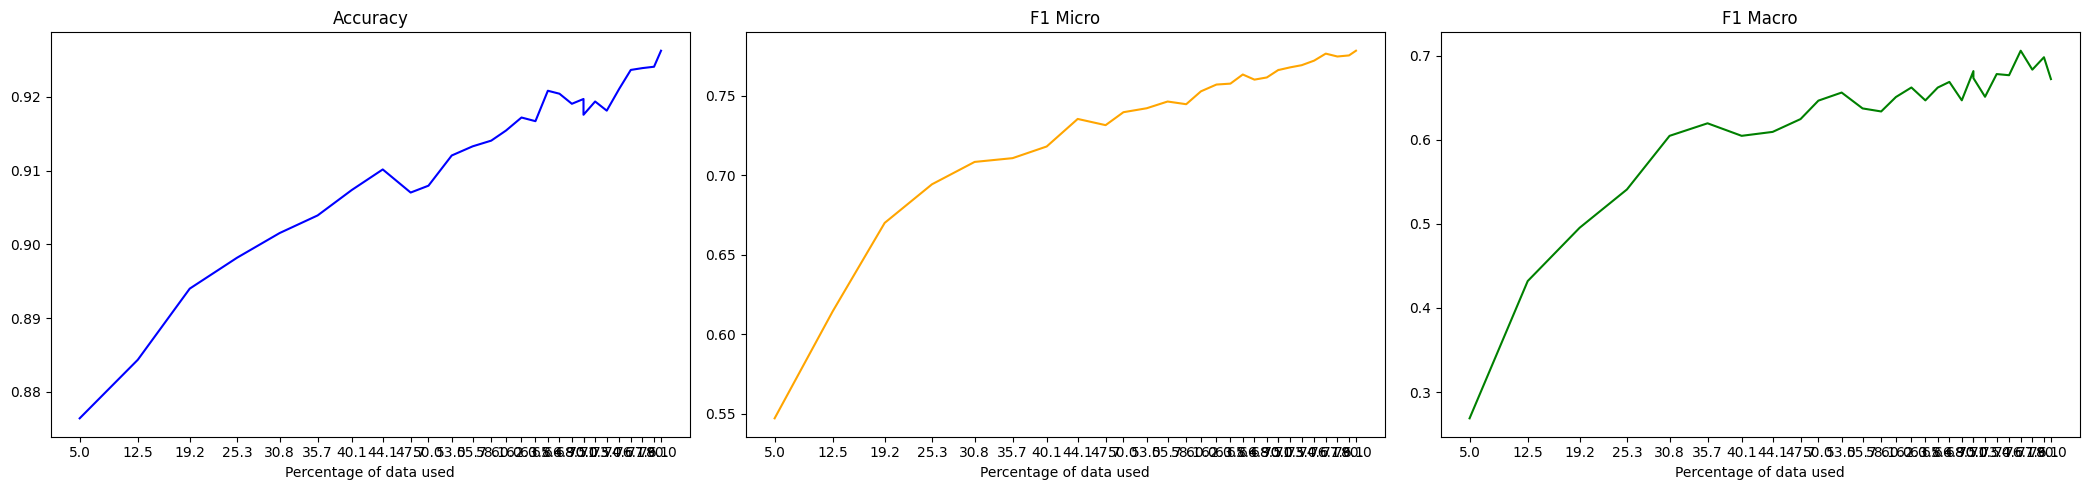

In [19]:
active_learning(seeds[0], 0)